In [1]:
#| default_exp fmf_biobert

# Found My Fitness Example
>"Here we'll try using elements from the biobertApi module to label biomedical terms in the comments section of a Found My Fitness Youtube video"

In [2]:
#|hide
from biobert_bern.biobertApi import *

Less than 5k characters. Only 1 block necessary.


In [3]:
# !pip install pathlib

In [4]:
import requests
import re
import pandas as pd
from nbdev.showdoc import *
import fastai
from pathlib import *
import numpy as np     

In [5]:
path = Path('../..')
comment_csv= 'found_my_fitness_UCWF8SqJVNlx-ctXbLswcTcA_youtube_comments_only_122rows.csv'

In [6]:
coms = pd.read_csv(path/comment_csv)

In [7]:
coms.rename(columns = {'comment': 'comments'},inplace=True)

In [8]:
coms.tail(2)

,vid_id,vid_channel_id,vid_deets,vid_response,title,publishedAt,tcomment_id,tcresponse,textDisplay,textOriginal,totalReplyCount,rep_comment,reply_id,comments
120,g4QqJoox8tc,NaN,NaN,NaN,NaN,2022-11-02T11:20:13Z,NaN,"{'kind': 'youtube#comment', 'etag': 'yd5KSzb3_...",... and they said it gives you the munchies.,... and they said it gives you the munchies.,NaN,"{'kind': 'youtube#comment', 'etag': 'yd5KSzb3_...",Ugy2ZO2t370rDO-eWoZ4AaABAg.9husbe2WJcN9hvjM9rBbfr,... and they said it gives you the munchies.
121,g4QqJoox8tc,NaN,NaN,NaN,NaN,2022-11-02T03:07:55Z,Ugx3lPLxH7NyOIZxzEl4AaABAg,"{'kind': 'youtube#commentThread', 'etag': 'Gzv...",My first thought was Rich Roll,My first thought was Rich Roll,0.0,NaN,NaN,My first thought was Rich Roll


## Now start splitting off all the cumsums <5000 and stack them back together.

### Create Section Labels

In [9]:
coms = create_com_with_idx(coms)

# Create Text Block
> Here we'll put all the text together

In [10]:
# coms = coms[['textDisplay']]
# coms.rename(columns={'textDisplay':'comments'},inplace=True)

## First create a single big text_block

In [11]:
text_block = create_one_large_text_block(df=coms); text_block[:250]

'0:: if exercise and/or the interaction with alcohol behaviors has really piqued your interest, make sure to check out my recent "sober october" post series found on my instagram: https://www.instagram.com/foundmyfitness support the show as a premium '

In [12]:
# df =coms
# df = make_5k_sections(df)
# blocks = []
# for o in df.section.unique():
#     dfbl = df.loc[df.section == o]
#     text_block = ' '.join(dfbl.comidx.tolist())
#     blocks.append(text_block)

In [13]:
# text_block = create_text_block(df=coms);# text_block
blocks = create_all_text_blocks(df=coms)

/notebooks/git/biobertapi1/biobert-bern/biobert_bern/biobertApi.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dffk['section'] = counter
/notebooks/git/biobertapi1/biobert-bern/biobert_bern/biobertApi.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cumTxtLen'] = df.textLen.cumsum()


In [14]:
for o in blocks: print(o[:50]); print()

0:: if exercise and/or the interaction with alcoho

28:: that's hilarious. my alcoholic triathlete bro

43:: as one of the most severe alcoholics ever bor

60:: i really really really appreciate this concis

77:: as a recovering alcoholic, damn sign me up fo

99:: i have to force myself, both to do exercise a



### Get Comment Spans

In [15]:
# dfi = get_comment_spans_textblock(text_block); dfi.tail(3)

In [16]:
# # Send it all to Bern2
# output = query_plain(text=text_block);  

## Query BERN one block at a time

In [18]:
dfo = pd.DataFrame()
for o in blocks:
    print(len(o))
    out = query_plain(text=o)
    dfo = dfo.append({'block':o, 'out':out},ignore_index=True)
dfo.tail(2)

4811
3092
4853
3668
4865
3182


,block,out
4,"77:: as a recovering alcoholic, damn sign me u...","{'annotations': [{'id': ['mesh:D000437', 'mim:..."
5,"99:: i have to force myself, both to do exerci...","{'annotations': [{'id': ['CHEBI:16236'], 'is_n..."


# DfO = df

In [19]:
# df = dfo
# dfo = df

In [156]:
import numpy as np

In [117]:
def merge_annotations_with_textblock_idx(dfa,#daframe containing 'span' column with the text locations of each 
                                         dfi):
    # create str_end col as type str
    dfa.span = dfa.span.astype(str)
    dfa ['str_end'] = dfa.span.str.replace(r".*'end': (\d+)}",r"\1",regex=True)
    dfa.str_end = dfa.str_end.astype(int)  # make str end as type str

    #add dfi_idx col
    dfi.reset_index(inplace=True)
    dfi.rename(columns={'index':'dfi_bloc_idx'},inplace=True)
    dfi.dfi_bloc_idx = dfi.dfi_bloc_idx.astype(int)
    # create com_idx pulling it from the text via regex
    dfi['comidx'] = dfi.text.replace(r"((\d+)?::.*)",r"\2",regex=True)
    dfi.comidx = dfi.comidx.astype(int)
    print(type(dfi.comidx[0]))
    dfi.comidx = dfi.comidx.astype(int)

    for o,m in zip(dfi.index,dfi.span):  #add dfi_idx col to dfa 
        x,y = m #open span tuple
        #write conditions for specific df rows
        conds = (dfa.str_end > x) & (dfa.str_end < y)
        dfa['dfi_bloc_idx'] = ''
        dfa.loc[conds,'dfi_bloc_idx'] = o #save the index of the dfi span that fits to dfa
        dfa.dfi_bloc_idx = dfa.dfi_bloc_idx.astype(str)
    # dfa.merge(dfi, left_on='dfi_idx',right_index=True)
    df = dfa.merge(dfi, left_on='dfi_bloc_idx',right_on='dfi_bloc_idx');
    
    return df

# Concat All Text Blocks into a nice labeled df

In [179]:
df = pd.DataFrame()
for o in dfo.index:
    dfa  =pd.DataFrame(dfo.out[o]['annotations'])
    dfi = get_comment_spans_textblock(dfo.block[o])
    dfmerg = merge_annotations_with_dfi_bloc_idx(dfa,dfi)
    df = pd.concat([df,dfmerg])

In [175]:
def dfi_dfa_prep(dfa,dfi):
    '''Prepares dfi and dfa to both have dfi_bloc_idx'''
    dfi.reset_index(drop=True,inplace=True)
    dfi['dfi_bloc_idx'] = dfi.index
    # dfi.rename(columns={'index':'dfi_bloc_idx'},inplace=True)
    dfi.dfi_bloc_idx = dfi.dfi_bloc_idx.astype(int)
    # create com_idx pulling it from the text via regex
    dfi['comidx'] = dfi.text.replace(r"((\d+)?::.*)",r"\2",regex=True)
    dfi.comidx = dfi.comidx.astype(int)

    # create str_end col as type str
    dfa.span = dfa.span.astype(str)
    dfa ['str_end'] = dfa.span.str.replace(r".*'end': (\d+)}",r"\1",regex=True)
    dfa.str_end = dfa.str_end.astype(int)  # make str end as type str
    dfa['dfi_bloc_idx'] = ''
    return dfa,dfi

In [176]:
def merge_annotations_with_dfi_bloc_idx(dfa,#daframe containing 'span' column with the text locations of each 
                                         dfi):
    '''Merges dfa with dfi so that all 'mentions' and 'obj' have a comidx(comemnt index) and a dfi_bloc_idx(dfi textbock index). This way we can track how different people have comented on each biomedical word('mention')'''
    #prep dfi and dfa
    dfa,dfi = dfi_dfa_prep(dfa,dfi)
    
    #add dfi_bloc_idx col
    for o,m in zip(dfi.index,dfi.span):  #add dfi_idx col to dfa 
        x,y = m #open span tuple
        #write conditions for specific df rows
        conds = (dfa.str_end > x) & (dfa.str_end <= y)
        dfa.loc[conds,'dfi_bloc_idx'] = o #save the index of the dfi span that fits to dfa

    dfa.dfi_bloc_idx = dfa.dfi_bloc_idx.astype(int) #make column np.64
    # merge it all

    df = dfa.merge(dfi, left_on='dfi_bloc_idx',right_on='dfi_bloc_idx')
    return df

In [ ]:
dfi,dfa = dfi_dfa_prep(dfa,dfi)
df = merge_annotations_with_dfi_bloc_idx(dfa,dfi)

In [165]:
dfi.head(2)

,text,start,end,span,dfi_bloc_idx,comidx
0,0:: if exercise and/or the interaction with al...,0.0,328.0,"(0, 328)",0,0
1,"1:: hi rhonda, could this mean that ""one time""...",329.0,548.0,"(329, 548)",1,1


In [166]:
type(dfi.dfi_bloc_idx[0])

numpy.int64

In [167]:
type(dfa.dfi_bloc_idx[0])

numpy.int64

In [168]:
# dfmerg = merge_annotations_with_textblock_idx(dfa,dfi)
dfa.head(2)

,id,is_neural_normalized,mention,obj,prob,span,str_end,dfi_bloc_idx
0,[CHEBI:16236],False,alcohol,drug,0.993933,"{'begin': 44, 'end': 51}",51,0
1,[CUI-less],False,rhonda,species,0.365529,"{'begin': 333, 'end': 339}",339,1


In [169]:
dfa.tail(2)

,id,is_neural_normalized,mention,obj,prob,span,str_end,dfi_bloc_idx
23,"[mesh:D000437, mim:103780]",False,alcohol abuse disorder,disease,0.998955,"{'begin': 4359, 'end': 4381}",4381,23
24,[CHEBI:16236],False,alcohol,drug,0.907631,"{'begin': 4359, 'end': 4366}",4366,23


In [132]:
dfi.tail(2)

,text,start,end,span
26,26:: i can’t thank you enough for your informa...,4561.0,4670.0,"(4561, 4670)"
27,"27:: you’ve literally changed my life, girl. a...",4671.0,4811.0,"(4671, 4811)"


In [42]:
# combine_annotations(df)

NameError: name 'combine_annotations' is not defined

## attach each ann. to it's comment id

In [133]:
df.out

AttributeError: 'DataFrame' object has no attribute 'out'

In [20]:
def combine_annotations(df):
    dfa = pd.DataFrame()
    for p,o in zip(df.index, df.out):    
        dft = pd.DataFrame(o['annotations'])
        dft['comidx'] = p
        dfa = dfa.append(dft)
    return dfa

dfa = combine_annotations(df) #extract all annotations into separate rows

In [21]:
dfi = get_comment_spans_textblock(text_block); dfi

,text,start,end,span
0,0:: if exercise and/or the interaction with al...,0.0,328.0,"(0, 328)"
1,"1:: hi rhonda, could this mean that ""one time""...",329.0,548.0,"(329, 548)"
2,2:: it’s a great series! highly suggest 💪👏💓,549.0,595.0,"(549, 595)"
3,"3:: thank you so much for researching, organiz...",596.0,1483.0,"(596, 1483)"
4,"4:: didn't know about this, but i'm a living a...",1484.0,1540.0,"(1484, 1540)"
...,...,...,...,...
117,117:: how to combat increased food intake afte...,23969.0,24196.0,"(23969, 24196)"
118,118:: it's brutal. get the garbage food out of...,24197.0,24357.0,"(24197, 24357)"
119,119:: go animal based,24358.0,24382.0,"(24358, 24382)"
120,120:: ... and they said it gives you the munch...,24383.0,24436.0,"(24383, 24436)"


In [22]:
dfa

,id,is_neural_normalized,mention,obj,prob,span,comidx
0,[CHEBI:16236],False,alcohol,drug,0.993933,"{'begin': 44, 'end': 51}",0
1,[CUI-less],False,rhonda,species,0.365529,"{'begin': 333, 'end': 339}",0
2,[CUI-less],False,ayahuasca,species,0.641253,"{'begin': 408, 'end': 417}",0
3,[CHEBI:8614],False,psylocybin,drug,0.998769,"{'begin': 421, 'end': 431}",0
4,[CHEBI:16236],False,alcohol,drug,0.781949,"{'begin': 467, 'end': 474}",0
...,...,...,...,...,...,...,...
6,[CHEBI:16236],False,alcohol,drug,0.999161,"{'begin': 1322, 'end': 1329}",5
7,[CUI-less],False,robin,species,0.571512,"{'begin': 1597, 'end': 1602}",5
8,[mesh:D009369],False,cancer,disease,0.999829,"{'begin': 1889, 'end': 1895}",5
9,[mesh:D009497],False,depression,disease,0.787686,"{'begin': 2146, 'end': 2156}",5


In [60]:
df.tail(2)

,id,is_neural_normalized,mention,obj,prob,span_x,str_end,dfi_idx,text,start,end,span_y
9,[mesh:D009497],False,depression,disease,0.787686,"{'begin': 2146, 'end': 2156}",2156,14.0,113:: he had a heart operation that might have...,2089.0,2165.0,"(2089, 2165)"
10,[CHEBI:16236],False,alcohol,drug,0.997428,"{'begin': 2735, 'end': 2742}",2742,18.0,117:: how to combat increased food intake afte...,2675.0,2902.0,"(2675, 2902)"


In [57]:
dfwords = df.groupby(['mention','obj']).id.count().reset_index().sort_values('id',ascending=False)
dfwords.reset_index(drop=True,inplace=True)
dfwords

,mention,obj,id
0,alcohol,drug,21
1,fgf21,gene,11
2,alcoholic,disease,6
3,people,species,5
4,alcoholism,disease,3
5,alcoholics,disease,3
6,fgf-21,gene,2
7,naltrexone,drug,2
8,cancer,disease,2
9,humans,species,2


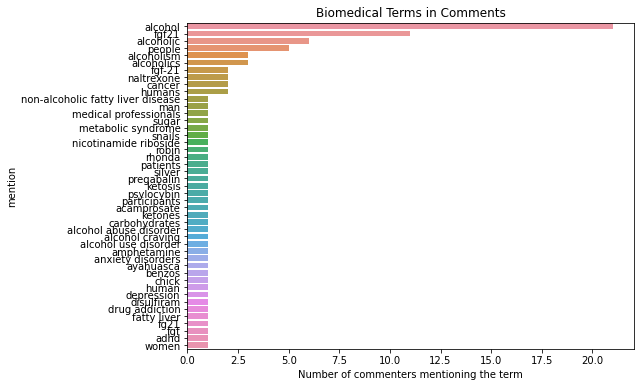

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the width and height of the figure
plt.figure(figsize=(8,6))

ax = sns.barplot(x=dfwords.id, y=dfwords.mention)

#title
ax.set_title(f'Biomedical Terms in Comments')

# Add label for  axis
ax.set(xlabel='Number of commenters mentioning the term')
plt.show()